In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times']
plt.rcParams['mathtext.fontset'] = 'stix'

from scipy.ndimage import distance_transform_edt
from sionna.rt import load_scene
import sionna

import mitsuba as mi

In [2]:
def prep_nearest_map(Z: np.ndarray) -> np.ndarray:
    """
    Precompute nearest valid (row, col) indices for every pixel.

    Parameters:
        Z : np.ndarray
            Height map array with NaNs for invalid points.
        
    Returns:
        nearest_idx : np.ndarray
            The feature transform of index of the closest background element to each foreground element.
    """
    valid = ~np.isnan(Z)
    nearest_idx = distance_transform_edt(
        ~valid, return_distances=False, return_indices=True
    )
    nearest_idx = np.asarray(nearest_idx)

    return nearest_idx 


def world_to_index(x: float, y: float, meta: dict[str, float]) -> tuple[int, int]:
    """
    Convert world coordinates to height map indices.
    
    Parameters:
        x : float
            World x coordinate.
        y : float
            World y coordinate.
        meta : dict[str, float]
            Grid metadata. Contains 'xmin', 'xmax', 'ymin', 'ymax', 'h', 'nx', 'ny'.

    Returns:
        (i, j) : tuple of ints
            Height map indices corresponding to the given world coordinates.
    """
    i = int(np.clip(np.round((x - meta["xmin"])/meta["h"]), 0, meta["nx"]-1))  # col (x)
    j = int(np.clip(np.round((y - meta["ymin"])/meta["h"]), 0, meta["ny"]-1))  # row (y)

    return i, j


def index_to_world(i: int, j: int, meta: dict[str, float]) -> tuple[float, float]:
    """
    Convert height map indices to world coordinates.
    
    Parameters:
        i : int
            Column index (x direction).
        j : int
            Row index (y direction).
        meta : dict[str, float]
            Grid metadata. Contains 'xmin', 'xmax', 'ymin', 'ymax', 'h', 'nx', 'ny'.
            
    Returns:
        (x, y) : tuple of floats
            World coordinates corresponding to the given indices.
    """
    x = meta["xmin"] + i * meta["h"]
    y = meta["ymin"] + j * meta["h"]

    return x, y


def snap_to_nearest_valid_height(
        x: float, y: float, 
        Z: np.ndarray, 
        nearest_idx: np.ndarray, 
        meta: dict[str, float]
        ) -> tuple[float, float, float]:
    """
    Snap world coordinates to nearest valid height map point.
    
    Parameters:
        x : float
            World x coordinate.
        y : float
            World y coordinate.
        Z : np.ndarray
            Height map array with NaNs for invalid points.
        nearest_idx : np.ndarray
            Precomputed nearest valid indices for each pixel.
        meta : dict[str, float]
            Grid metadata. Contains 'xmin', 'xmax', 'ymin', 'ymax', 'h', 'nx', 'ny'.

    Returns:
        (x_snapped, y_snapped, z_snapped) : tuple of floats
            Snapped world coordinates and corresponding height value.
    """
    i, j = world_to_index(x, y, meta)

    j_valid, i_valid = nearest_idx[:, j, i]
    z_snapped = float(Z[j_valid, i_valid])

    x_snapped, y_snapped = index_to_world(i_valid, j_valid, meta)
    
    return x_snapped, y_snapped, z_snapped


def plot_height_map(
    Z: np.ndarray, 
    meta: dict[str, float],
    txs: dict[str, dict[str, float]] | None = None,
    cmap: str = 'viridis',
    title: str = 'Ray-casted height map',
    xlabel: str = 'x (m)',
    ylabel: str = 'y (m)',
    colorbar_label: str = 'Height (m)',
    show_title: bool = True,
    show_axis: bool = True,
    show_colorbar: bool = True,
    ) -> None:
    """
    Plot top-down view of the height map.

    Parameters:
        Z : np.ndarray
            Height map 2D array.
        meta : dict[str, float]
            Grid metadata. Contains 'xmin', 'xmax', 'ymin', 'ymax', 'h', 'nx', 'ny'.
        txs : dict[str, dict[str, float]], optional
            Dictionary of transmitter locations to plot, 
            where keys are labels and values are (x, y) coordinates.
        cmap : str, optional
            Colormap to use for the height map.
        title : str, optional
            Title of the plot.
        xlabel : str, optional
            Label for the x-axis.
        ylabel : str, optional
            Label for the y-axis.
        colorbar_label : str, optional
            Label for the colorbar.
        show_title : bool, optional
            Whether to display the title.
        show_axis : bool, optional
            Whether to display the axis.
        show_colorbar : bool, optional
            Whether to display the colorbar.
    """
    plt.figure(figsize=(6, 5))
    im = plt.imshow(
            Z,
            origin="lower",
            cmap=cmap,
            extent=(float(meta["xmin"]), float(meta["xmax"]), float(meta["ymin"]), float(meta["ymax"]))
    )

    if txs is not None:
        for label, data in txs.items():
            x = data["x"]
            y = data["y"]
            color = data.get("color", None)
            plt.scatter(x, y, label=label, s=35, edgecolors="black", linewidths=0.5, color=color)
        plt.legend()

    if show_colorbar:
        plt.colorbar(im, label=colorbar_label)

    if show_axis:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    else:
        plt.axis("off")

    if show_title:
        plt.title(title)

    plt.tight_layout()
    plt.show()


def height_map_raycasted(
        scene,
        step_size: float = 1.0,
        direction: tuple[float, float, float] = (0.0, 0.0, -1.0)
    ) -> tuple[np.ndarray, dict]:
    """
    Height map via batched Mitsuba ray casting.

    For each (x, y) grid point we:
      - cast a ray from above (z_top → down) to get the first hit z_hit
      - optionally cast a ray from below (z_bottom → up) to get local ground z_ground
      - optionally keep only hits whose height above ground is >= min_rel_height

    Parameters:
        scene : sionna.rt.Scene
            Scene with .mi_scene (Mitsuba scene).
        step_size : float
            Grid spacing in meters.

    Returns:
        Z : np.ndarray, shape (ny, nx)
            Height map (meters), NaN where no valid object remains.
        meta : dict
            {'xmin','xmax','ymin','ymax','h','nx','ny'}
    """
    mi_scene = scene.mi_scene
    bbox = mi_scene.bbox()

    h = float(step_size)
    xmin, xmax = float(bbox.min.x), float(bbox.max.x)
    ymin, ymax = float(bbox.min.y), float(bbox.max.y)
    z_top = float(bbox.max.z)

    # Build grid
    x_vals = np.arange(xmin, xmax + h, h)
    y_vals = np.arange(ymin, ymax + h, h)
    nx, ny = len(x_vals), len(y_vals)

    X, Y = np.meshgrid(x_vals, y_vals)
    Xf = mi.Float(X.ravel())                                # type: ignore
    Yf = mi.Float(Y.ravel())                                # type: ignore
    Zf = mi.Float(np.full(X.size, -z_top * direction[2]))   # type: ignore

    ray = mi.Ray3f(
        o=mi.Point3f(Xf, Yf, Zf),
        d=mi.Vector3f(*direction)
    )
    si = mi_scene.ray_intersect(ray)
    z_hit = si.p.z                  # Dr.Jit Float
    valid = si.is_valid()           # Dr.Jit Bool
    mask = valid

    z_np = np.array(z_hit, dtype=float)
    mask_np = np.array(mask, dtype=bool)
    z_np[~mask_np] = np.nan

    Z = z_np.reshape(ny, nx)
    meta = {
        "xmin": xmin, "xmax": xmax,
        "ymin": ymin, "ymax": ymax,
        "h": h, "nx": nx, "ny": ny,
    }
    return Z, meta


def generate_height_map(
        scene,
        step_size: float = 1.0,
        min_height: float | None = None,
    ) -> tuple[np.ndarray, dict]:
    """
    Fast height map using batched Mitsuba ray casting (no Python loops).

    For each (x, y) on a regular grid, we cast a single downward ray from
    the top of the scene and record the first hit z.

    Parameters:
        scene : sionna.rt.Scene
            Scene with mi_scene backend.
        step_size : float
            Lattice spacing for sampling (meters).
        min_height : float | None
            Minimum *relative object height* to keep (based on the difference
            between the top-down and bottom-up raycasted heights). If None,
            no minimum height filtering is applied. Otherwise, hits where the
            difference is below min_height are removed. Therefore, specifying
            min_height removes low-height structures, including ground.

    Returns:
        Z : np.ndarray, shape (ny, nx)
            Height map where Z[j,i] is the hit height in meters, or NaN.
        meta : dict[str, float]
            {'xmin', 'xmax', 'ymin', 'ymax', 'h', 'nx', 'ny'}.
    """
    Z_top_down, meta = height_map_raycasted(
        scene=scene, step_size=step_size, direction=(0.0, 0.0, -1.0)
    )
    Z = Z_top_down.copy()
    mask = ~np.isnan(Z)

    # Remove values if difference is below min_height
    if min_height is not None:
        Z_down_top, _ = height_map_raycasted(
            scene=scene, step_size=step_size, direction=(0.0, 0.0, 1.0)
        )
        z_diff = Z_top_down - Z_down_top
        mask &= ~(~np.isnan(z_diff) & (z_diff < min_height))
    
    Z[~mask] = np.nan
    return Z, meta

In [3]:
scene = load_scene(sionna.rt.scene.etoile, merge_shapes=False)

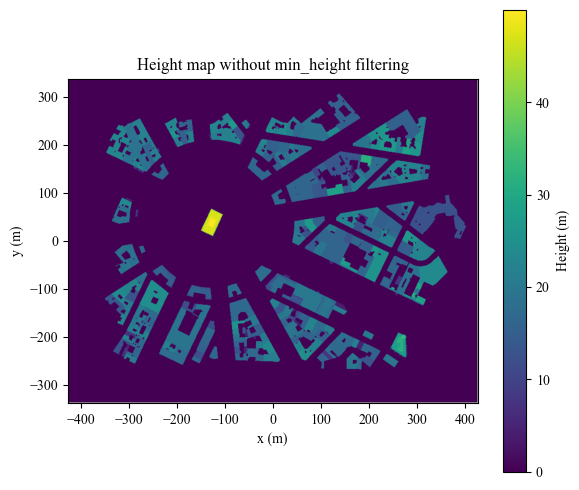

In [4]:
Z, meta = generate_height_map(
    scene=scene, step_size=1.0, min_height=None
    )
plot_height_map(Z, meta, title='Height map without min_height filtering')

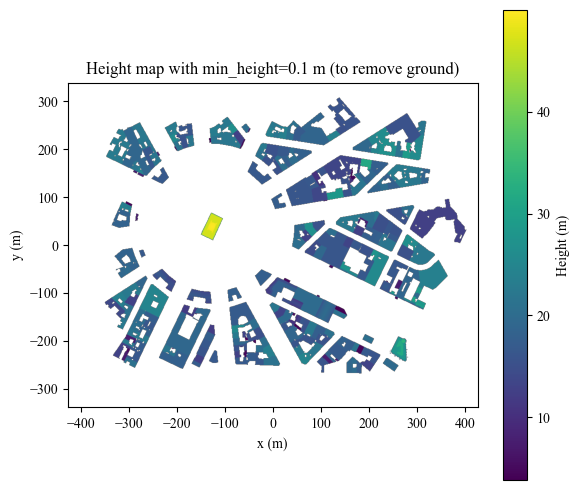

In [5]:
Z, meta = generate_height_map(
    scene=scene, step_size=1.0, min_height=0.1
    )
plot_height_map(Z, meta, title='Height map with min_height=0.1 m (to remove ground)')

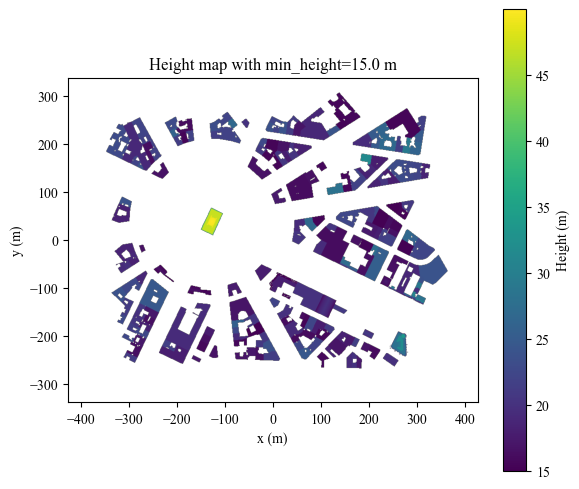

In [6]:
Z, meta = generate_height_map(
    scene=scene, step_size=1.0, min_height=15.0
    )
plot_height_map(Z, meta, title='Height map with min_height=15.0 m')

Original Tx: (-60, 10)
Snapped Tx: (-114.831, 31.940) with height 41.0


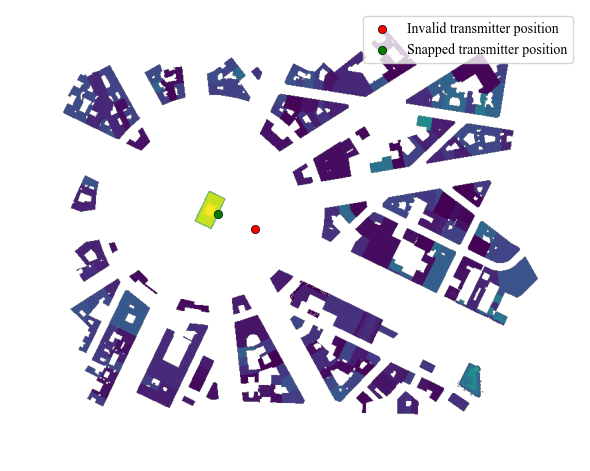

In [7]:
nearest_map = prep_nearest_map(Z)

tx_invalid = (-60, 10)      # Some invalid tx location
x_snapped, y_snapped, z_snapped = snap_to_nearest_valid_height(
    *tx_invalid, Z, nearest_map, meta
)

print(f"Original Tx: {tx_invalid}")
print(f"Snapped Tx: ({x_snapped:.3f}, {y_snapped:.3f}) with height {z_snapped}")

txs = {
    "Invalid transmitter position": {"x": tx_invalid[0], "y": tx_invalid[1], "color": 'red'},
    "Snapped transmitter position": {"x": x_snapped, "y": y_snapped, "color": 'green'}
}

plot_height_map(Z, meta, txs=txs, show_axis=False, show_title=False, show_colorbar=False)